In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.integrate import trapezoid
from scipy.interpolate import interp1d

<p align="center">
  <img src="https://github.com/marcus-valmeida/Projeto-conversao/blob/medupl/circuito_exercicio2.png?raw=true" alt="Circuito Exercício 1" width="500"/>
</p>

In [2]:
#Dados da questão
R = 4*1e-2
D = 15*1e-2
N1  = 90
lc = 25*1e-2
U0  = 4*np.pi*1e-7
alpha  = np.pi / 3
g = 2*1e-3
num_pontos = 200

#caso real
CampoMagnetico = np.array([0, 68, 135, 203, 271, 338, 406, 474, 542, 609, 1100, 1500, 2500, 4000, 5000, 9000, 12000, 20000, 25000])
DensidadeCampo = np.array([0, 0.733, 1.205, 1.424, 1.517, 1.560, 1.588, 1.617, 1.631, 1.646, 1.689, 1.703,1.724, 1.731, 1.738, 1.761, 1.770, 1.800, 1.816])

#caso linear
CampoMagnetico_linear = np.array([0, 68])
DensidadeCampo_linear = np.array([0, 0.733])

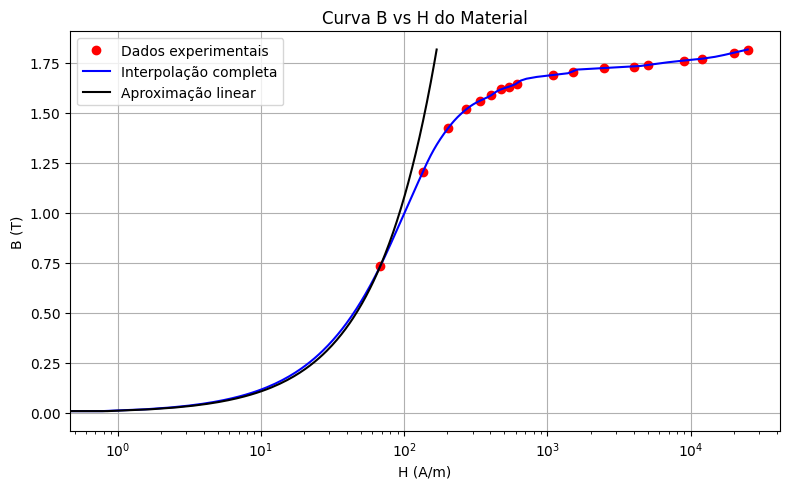

In [3]:
# Interpolação cúbica (ordem crescente de B)
f_real = CubicSpline(DensidadeCampo, CampoMagnetico, bc_type='natural')
f_linear = CubicSpline(DensidadeCampo_linear, CampoMagnetico_linear, bc_type='natural')

# Geração de pontos para interpolação
B_a = np.linspace(min(DensidadeCampo), max(DensidadeCampo), num_pontos)
H_a = f_real(B_a)
H_linear_a = f_linear(B_a)

# Plotagem
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(CampoMagnetico, DensidadeCampo, 'ro', label='Dados experimentais')
ax.plot(H_a, B_a, 'b-', label='Interpolação completa')
ax.plot(H_linear_a, B_a, 'k-', label='Aproximação linear')

ax.set_title('Curva B vs H do Material')
ax.set_xlabel('H (A/m)')
ax.set_ylabel('B (T)')
ax.set_xscale('log')
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

#### Considere que o controlador do sistema aplica corrente em apenas uma bobina de cada vez.

- Apresente um gráfico do fluxo concatenado na bobina 1 em função da corrente aplicada nessa bobina considerando a posição do rotor variando da posição 0° até 60°.
    - Observação: seu gráfico terá uma curva de fluxo em função da corrente para cada posição. Se
você fizer o plot para todas as posições que calcular, a figura fica sobre carregada. Sugiro
fazer o plot com cerca de 10 posições diferentes ( ou seja, 0, 6, 12... 60°).

In [4]:
def area_eficaz(theta):

    #limitando de 0 a 360 graus
    theta = np.mod(theta, np.pi)

    #0 até 30 graus
    if (0 <= theta <= np.pi/6):
        return R * D * (np.pi/3 - theta)
    
    #30 até 60 graus ou 120 até 150 graus
    elif (np.pi/6 < theta <= np.pi/3) or (2*np.pi/3 < theta <= 5*np.pi/6):
        return R * D * (np.pi/6)
    
    #150 até 180 graus
    elif (5*np.pi/6 < theta <= np.pi):
        return R * D * (theta - 2*np.pi/3)
    
    else :
        return 0

def fluxo_concatenado(area, corrente, B, operacao, Interpolacao_H_B):

    # Inicialmente iremos calcular a relutância do circuito magnético
    relutancia = np.inf if area == 0 else (2*g)/(U0 * area)

    # Agora podemos calcular o fluxo magnético
    if operacao == "real":

        if area == 0:
            fluxo = 0
            corrente = 0

        else:
            # Como o fluxo no núcleo é o mesmo, e a área dos polos são iguais temos que B0 = B
            B0 = B
            
            # Calcula a intensidade de campo magnético (H) no entreferro (H = B / μ0)
            H0 = B0 / U0

            # Aplica a Lei de Hopkinson para encontrar a corrente necessária
            # Soma (MMF do núcleo + MMF do entreferro) e divide pelo número de espiras
            corrente = (Interpolacao_H_B(B) * lc + 2 * H0 * g) / N1
            
            # Calcula o fluxo concatenado (λ = N * B * A)
            fluxo = B * area * N1 
    
    elif operacao == "linear":
        ## Modelo linear: a relutância é constante, e o fluxo é diretamente proporcional à corrente.
        fluxo = 0 if relutancia == np.inf else ((N1**2) * corrente) / relutancia

    return fluxo, corrente

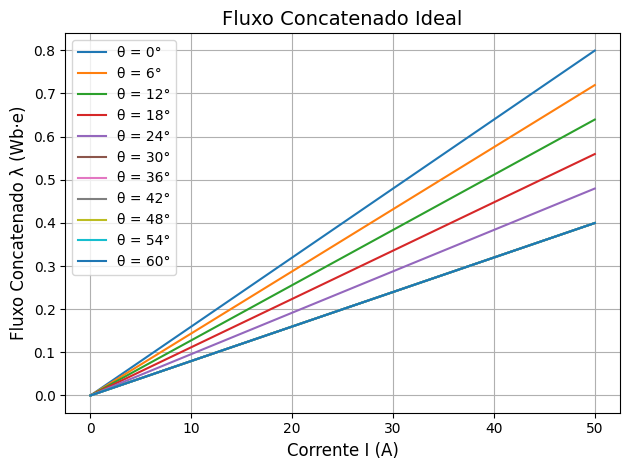

In [5]:
# Dados para o Fluxo Concatenado Ideal
correntes_linear = np.linspace(0, 50, 300)
angulos_deg = np.linspace(0, 60, 11)
angulos_rad = np.radians(angulos_deg)

Interpolacao_H_B = interp1d(DensidadeCampo, CampoMagnetico, kind='linear', fill_value='extrapolate')

plt.figure()
for theta in angulos_rad:
    area = area_eficaz(theta)
    
    # Gera a lista de fluxos ideal para o ângulo atual
    fluxos_ideal = [fluxo_concatenado(area, i, 0.733, "linear", Interpolacao_H_B)[0] for i in correntes_linear]

    plt.plot(correntes_linear, fluxos_ideal, label=f'θ = {np.degrees(theta):.0f}°')

plt.title('Fluxo Concatenado Ideal', fontsize=14)
plt.xlabel('Corrente I (A)', fontsize=12)
plt.ylabel('Fluxo Concatenado λ (Wb·e)', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




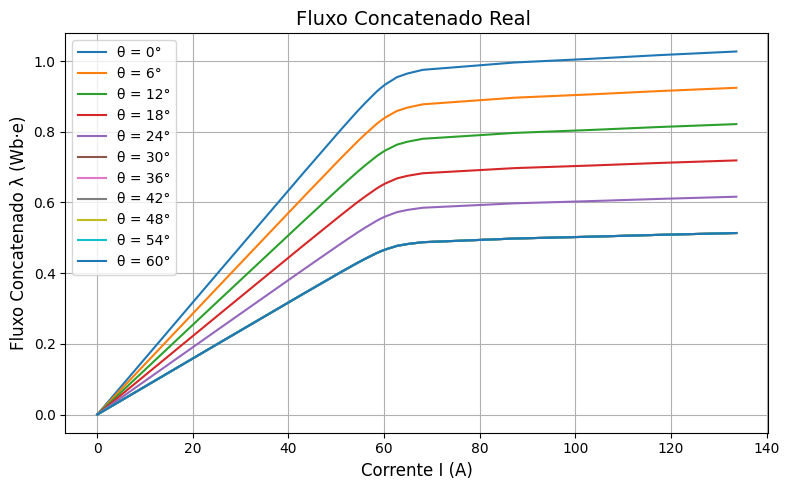

In [6]:
# Dados para o Fluxo Concatenado Real
densidade_campo_real = np.linspace(min(DensidadeCampo), max(DensidadeCampo), 100)

plt.figure(figsize=(8,5))
for theta in angulos_rad:
    area = area_eficaz(theta)
    if area == 0:
        continue
    
    # Gera as listas de fluxos e correntes para o ângulo atual
    fluxo_corrente_real = [fluxo_concatenado(area, None, B, "real", Interpolacao_H_B) for B in densidade_campo_real]
    
    fluxos_reais = [item[0] for item in fluxo_corrente_real]
    correntes_reais = [item[1] for item in fluxo_corrente_real]

    plt.plot(correntes_reais, fluxos_reais, label=f'θ = {np.degrees(theta):.0f}°')

plt.title('Fluxo Concatenado Real ', fontsize=14)
plt.xlabel('Corrente I (A)', fontsize=12)
plt.ylabel('Fluxo Concatenado λ (Wb·e)', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

- Determine qual deve ser a corrente aplicada na bobina de modo a obter uma
densidade de fluxo de 1,8 T quando o rotor estiver na posição zero graus.

In [7]:
# Precisamos achar a corrente que gera 1.8T no entreferro
B = 1.8                                             # Densidade de fluxo magnético no entreferro dado na questão

H_nucleo = f_real(B)                                # Campo magnético no núcleo a partir da interpolação
H_entreferro = B / U0                               # Campo magnético no entreferro (H = B / μ0)

# Calculando a corrente aplicada
corrente_real = (H_nucleo * lc + 2 * H_entreferro * g) / N1

# No modelo ideal, o material do núcleo é considerado perfeito e não apresenta relutância.
# Consequentemente, a intensidade de campo magnético (H) necessária no núcleo é zero (Hnuc =0)
corrente_ideal = (2 * H_entreferro * g) / N1

print(f"A corrente aplicada necessária para gerar {B}T no entreferro é: {corrente_real:.4f} A")
print(f"A corrente ideal necessária para gerar {B}T no entreferro é: {corrente_ideal:.4f} A")

A corrente aplicada necessária para gerar 1.8T no entreferro é: 119.2175 A
A corrente ideal necessária para gerar 1.8T no entreferro é: 63.6620 A


#### Considere que a corrente calculada no item anterior é aplicada na bobina 1.

- Apresente um gráfico do Torque produzido pela bobina 1 em função da posição do rotor considerando que o núcleo seja ideal;

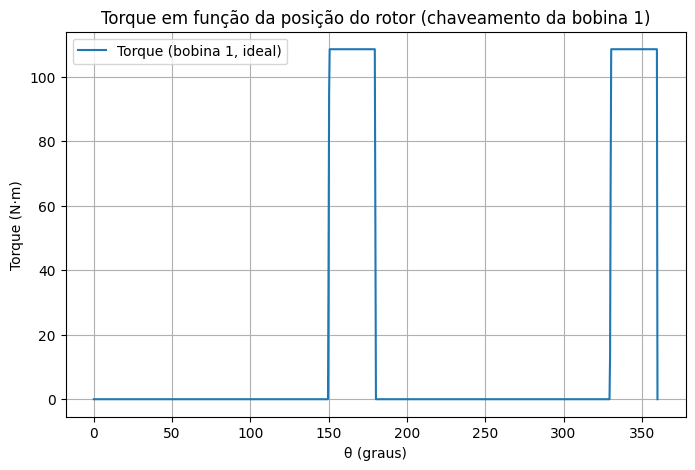

In [8]:
# Para um núcleo ideal, o torque (T) é gerado pela mudança na indutância (L) da bobina com o ângulo de rotação (θ).
# A relação é dada por T = k * I² * (dL/dθ), onde k é uma constante de proporcionalidade. k = 0.5

angulo_graus = np.linspace (0,360,1000)
angulo_rad = np.radians(angulo_graus)
L = np.zeros_like(angulo_rad)

for i, theta in enumerate(angulo_rad):
    L[i] = (N1**2 * U0 * area_eficaz(theta)) / (2*g)            # Indutância L = N^2 / Relutância

# Encontrando a derivada (dL/dθ)
derivada_L = np.gradient(L, angulo_rad)

def corrente_bobina1(theta):
    theta_deg = np.degrees(theta) % 360

    # Liga entre 120° e 180°
    if 120 <= theta_deg < 180:
        # Cresce linearmente de 0 até I_des nesse intervalo
        return corrente_real

    # Liga entre 300° e 360°
    elif 300 <= theta_deg < 360:
        return corrente_real

    else:
        return 0

torque_chaveado = []
for t, dLdt in zip(angulo_rad, derivada_L):
    I_t = corrente_bobina1(t)
    # Zera torque nos pontos de chaveamento (120° e 300°)
    theta = (np.degrees(t) % 360)
    if np.isclose(theta, 120, atol=0.5) or np.isclose(theta, 300, atol=0.5):
        torque_chaveado.append(0.0)
    else:
        torque_chaveado.append(0.5 * (I_t**2) * dLdt)

torque_chaveado = np.array(torque_chaveado)

plt.figure(figsize=(8,5))
plt.plot(angulo_graus, torque_chaveado, label="Torque (bobina 1, ideal)")
plt.xlabel('θ (graus)'); plt.ylabel('Torque (N·m)')
plt.title('Torque em função da posição do rotor (chaveamento da bobina 1)')
plt.grid(True)
plt.legend()
plt.show()

- Tópico 4
- Apresente um gráfico do Torque produzido pela bobina 1 em função
da posição do rotor considerando a característica real do núcleo;


In [9]:
# A função assume que constantes do motor estão definidas no escopo global
def calcular_coenergia(f_real, I_theta, theta_vals):
    coenergia = np.zeros_like(theta_vals)
    B_vals = np.linspace(0, np.max(DensidadeCampo), num_pontos)

    for i in range(len(theta_vals)):
        # Obtém os valores usando o índice 'i'
        theta = theta_vals[i]
        corrente = I_theta[i]
        area = area_eficaz(theta)

        # Se não houver corrente ou área, a coenergia é zero
        if (corrente <= 0) or (area <= 0):
            coenergia[i] = 0.0
            continue
            
        # Calcula a densidade de fluxo no entreferro
        B_entreferro = B_vals * (D*R / area) # Isso garante a relação de conservação de fluxo, Phi = B*A
        
        # Converte a varredura de B para varredura de corrente (i) usando a Lei de Hopkinson
        H_nucleo_vals = f_real(B_vals)
        H_entreferro_vals = B_entreferro / U0
        i_vals = (H_nucleo_vals * lc + H_entreferro_vals * 2 * g) / N1
        
        # Calcula o fluxo concatenado λ para cada B
        fluxo = N1 * area * B_vals
        
        # Prepara os dados para a interpolação: remove valores duplicados e ordena
        ord_ = np.argsort(i_vals)
        unique_i, idx = np.unique(i_vals[ord_], return_index=True)
        unique_lam = fluxo[ord_][idx]
        
        # Pula se não houver dados suficientes para interpolação
        if len(unique_i) < 2:
            coenergia[i] = 0.0
            continue
            
        # Cria a função de interpolação e define os pontos para a integração
        cs = CubicSpline(unique_i, unique_lam, bc_type='natural', extrapolate=False)
        I_end = min(corrente, unique_i[-1])
        I_int = np.linspace(0.0, I_end, 200)
        
        # Avalia a curva de lambda e calcula a coenergia via integração
        lam_interp = np.nan_to_num(cs(I_int), nan=0.0)
        coenergia[i] = trapezoid(lam_interp, I_int)
        
    return coenergia

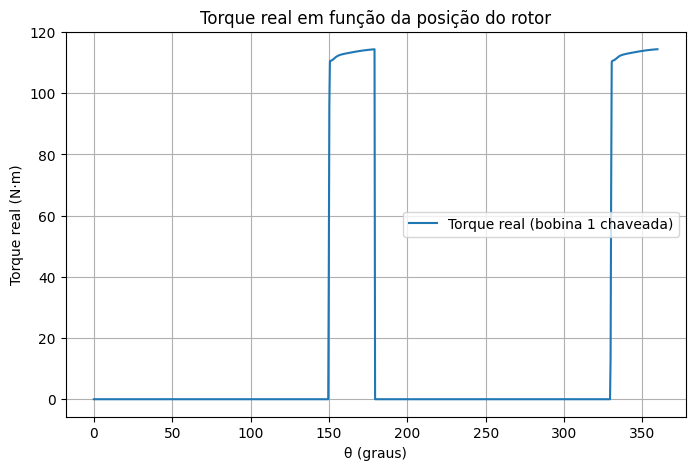

In [10]:
# Corrente por ângulo (mesma janela da Pergunta 3)
angulo_rad   = np.asarray(angulo_rad)
angulo_graus = np.asarray(angulo_graus)

I_theta = np.array([corrente_bobina1(t) for t in angulo_rad])

# --- Coenergia real (gatilhada) ---
coenergia_real = calcular_coenergia(f_real, I_theta, angulo_rad)

# --- Remove o ponto de 360° (mantém intervalo semiaberto [0, 360) ) ---
mask360            = angulo_graus < (360 - 1e-9)  # mesmo critério numérico
angulo_rad_cut     = angulo_rad[mask360]
angulo_graus_cut   = angulo_graus[mask360]
I_theta_cut        = I_theta[mask360]
coenergia_real_cut = coenergia_real[mask360]

# --- Torque = dWc/dθ ---
torque_real = np.gradient(coenergia_real_cut, angulo_rad_cut)

# --- Zera torque onde a bobina está desligada ---
mask_on = I_theta_cut > 0
torque_real[~mask_on] = 0

# --- Zera nos pontos de comutação (sem incluir 360° agora) ---
bounds_deg = np.array([0, 120, 180, 300])  # 360 removido
# mesmo critério de tolerância; só calculado a partir do passo angular
tol = max(0.5, (angulo_graus_cut[1] - angulo_graus_cut[0]) * 2)

# Usando broadcast para localizar índices equivalentes aos "np.where" do original
ang_mod   = np.remainder(angulo_graus_cut, 360.0)
bounds_md = np.remainder(bounds_deg, 360.0)

# Para cada bound, encontra posições ~iguais (com a mesma tolerância)
matches = np.isclose(ang_mod[:, None], bounds_md[None, :], atol=tol)
idx = np.nonzero(matches)[0]  # índices ao longo de angulo_graus_cut

torque_real[idx] = 0

# --- Plot ---
plt.figure(figsize=(8, 5))
plt.plot(angulo_graus_cut, torque_real, label='Torque real (bobina 1 chaveada)')
plt.xlabel('θ (graus)')
plt.ylabel('Torque real (N·m)')
plt.title('Torque real em função da posição do rotor')
plt.grid(True)
plt.legend()
plt.show()


#### Considere que a máquina está girando com uma velocidade constante em sentido anti-horário.

- Tópico 5
- Apresente um gráfico do valor eficaz do torque produzido pela
máquina em função da corrente aplicada nas bobinas considerando o
núcleo ideal;

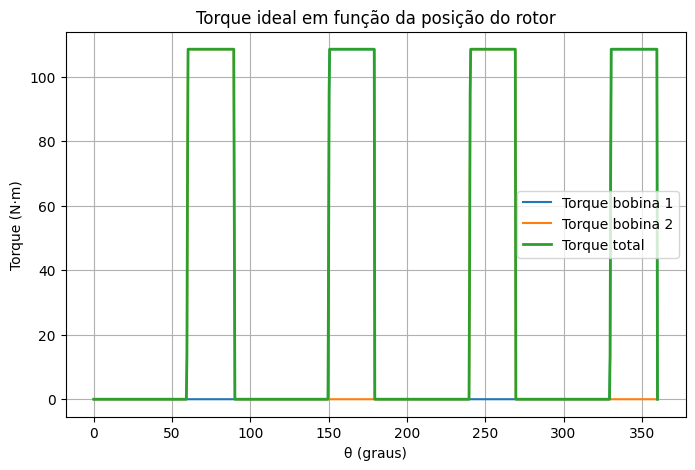

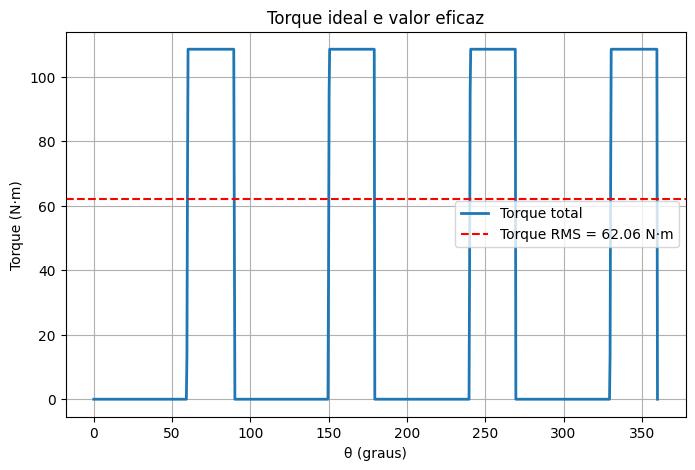

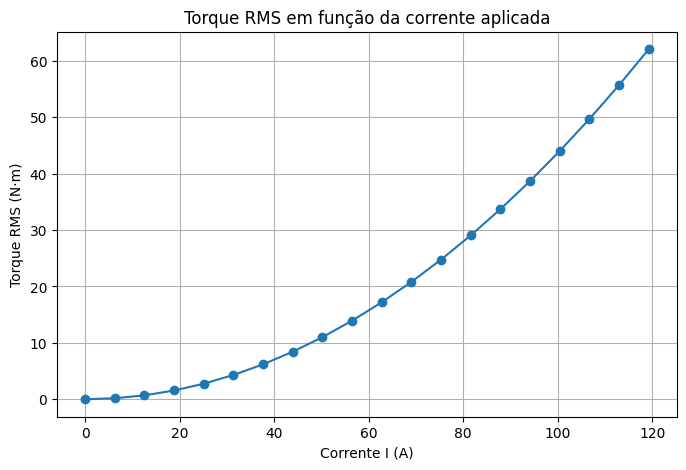

In [11]:
def corrente_bobina2(theta):
    ang = np.degrees(theta)
    ang_mod = ang % 360
    ativa = ((30 <= ang_mod < 90) or (210 <= ang_mod < 270))
    return corrente_real if ativa else 0

#Área eficaz da bobina 2
def area_eficaz_2(theta):
    #limitando de 0 a 180 graus
    theta = np.mod(theta, np.pi)


    if (0<= theta <np.pi/6):
        return 0


    elif (np.pi/6< theta <=np.pi/3):
        return D*R*np.pi/6


    elif (np.pi/3< theta <=np.pi/2):
        return D*R*(theta - np.pi/6)


    elif (np.pi/2< theta <= 2*np.pi/3):
        return D*R*(5*np.pi/6 - theta)


    elif (2*np.pi/3 < theta <5*np.pi/6):
        return D*R*np.pi/6


    elif (5*np.pi/6 < theta <np.pi):
        return 0
    else:
        return 0

def shift_array(arr, shift_rad, theta_array):
    shift = shift_rad / (theta_array[1] - theta_array[0])
    return np.roll(arr, int(np.round(shift)))


# --- Correntes em função de θ ---
I1_theta = np.array([corrente_bobina1(t) for t in angulo_rad])
I2_theta = np.array([corrente_bobina2(t) for t in angulo_rad])

# --- Indutâncias ---
L11 = np.array([(N1**2 * U0 * area_eficaz(t)) / (2 * g) for t in angulo_rad])
L22 = shift_array(L11, np.pi/2, angulo_rad)

# --- Derivadas das indutâncias ---
dL11_dtheta = np.gradient(L11, angulo_rad)
dL22_dtheta = np.gradient(L22, angulo_rad)

# --- Torques de cada bobina ---
torque_1 = 0.5 * (I1_theta**2) * dL11_dtheta
torque_2 = 0.5 * (I2_theta**2) * dL22_dtheta

# --- Torque total ---
torque_total = torque_1 + torque_2

# --- Zera torque nos pontos de comutação para remover picos ---
bounds_deg = np.array([120, 180, 210, 270, 300, 360])  # pontos de chaveamento
tol = max(0.5, (angulo_graus[1] - angulo_graus[0]) * 2)  # tolerância em graus
for b in bounds_deg:
    idx = np.where(np.isclose(angulo_graus % 360, b % 360, atol=tol))[0]
    torque_1[idx] = 0.0
    torque_2[idx] = 0.0
    torque_total[idx] = 0.0

# --- Plot ---
plt.figure(figsize=(8,5))
plt.plot(angulo_graus, torque_1, label="Torque bobina 1")
plt.plot(angulo_graus, torque_2, label="Torque bobina 2")
plt.plot(angulo_graus, torque_total, label="Torque total", linewidth=2)
plt.xlabel('θ (graus)')
plt.ylabel('Torque (N·m)')
plt.title('Torque ideal em função da posição do rotor')
plt.grid(True)
plt.legend()
plt.show()

# --- cálculo do RMS do torque total (uma volta completa) ---
torque_total_squared = torque_total**2
T_rms = np.sqrt(trapezoid(torque_total_squared, angulo_rad) / (angulo_rad[-1] - angulo_rad[0]))

# --- plot com linha horizontal indicando o RMS ---
plt.figure(figsize=(8,5))
plt.plot(angulo_graus, torque_total, label="Torque total", linewidth=2)
plt.axhline(T_rms, color='red', linestyle='--', label=f"Torque RMS = {T_rms:.2f} N·m")
plt.xlabel("θ (graus)")
plt.ylabel("Torque (N·m)")
plt.title("Torque ideal e valor eficaz")
plt.grid(True)
plt.legend()
plt.show()

#Definição das correntes a avaliar
correntes_rms = np.linspace(0, corrente_real, 20)  # 20 valores de corrente de 0 a I_des
torques_rms = []

for I in correntes_rms:
    # Escala as correntes das bobinas
    I1_theta_scaled = I1_theta * (I / corrente_real)
    I2_theta_scaled = I2_theta * (I / corrente_real)


    # Recalcula o torque com as correntes escaladas
    torque_1_scaled = 0.5 * (I1_theta_scaled**2) * dL11_dtheta
    torque_2_scaled = 0.5 * (I2_theta_scaled**2) * dL22_dtheta
    torque_total_scaled = torque_1_scaled + torque_2_scaled

    # Zera torque nos pontos de chaveamento (mesma lógica que antes)
    for b in bounds_deg:
        idx = np.where(np.isclose(angulo_graus % 360, b % 360, atol=tol))[0]
        torque_total_scaled[idx] = 0.0

    # Calcula torque RMS
    torque_total_squared = torque_total_scaled**2
    T_rms = np.sqrt(trapezoid(torque_total_squared, angulo_rad) / (angulo_rad[-1] - angulo_rad[0]))
    torques_rms.append(T_rms)

# --- Plot Torque RMS vs Corrente ---
plt.figure(figsize=(8,5))
plt.plot(correntes_rms, torques_rms, marker='o')
plt.xlabel('Corrente I (A)')
plt.ylabel('Torque RMS (N·m)')
plt.title('Torque RMS em função da corrente aplicada')
plt.grid(True)
plt.show()

- Tópico 6
- Apresente um gráfico do valor eficaz do torque produzido pela
máquina em função da corrente aplicada nas bobinas considerando a
característica real do núcleo;


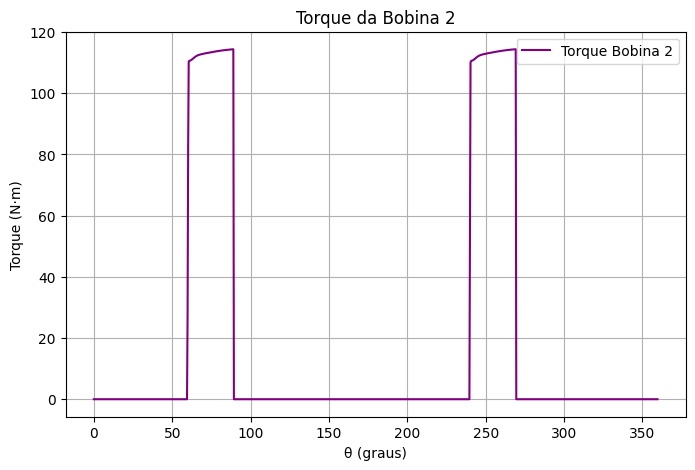

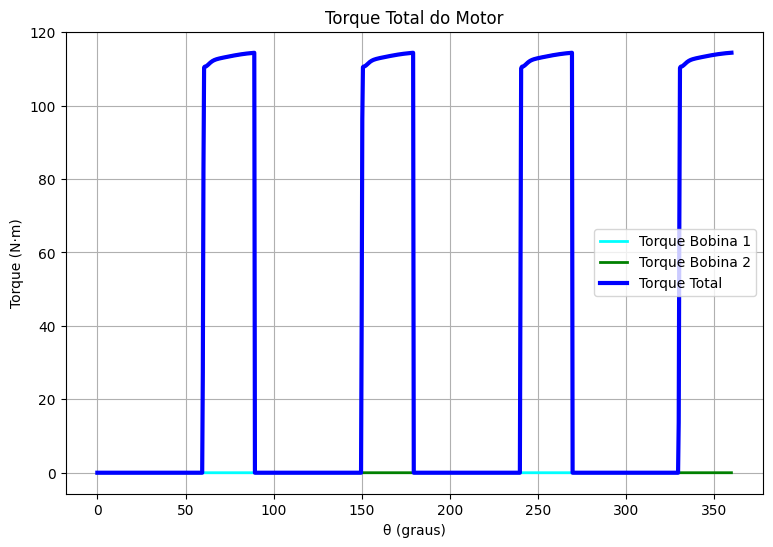

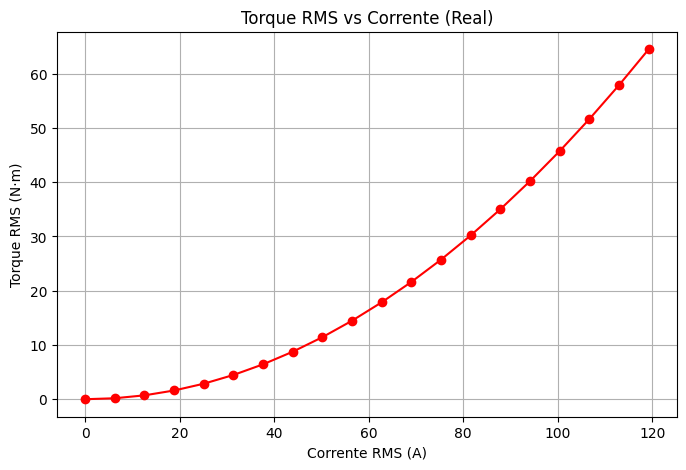

In [12]:
# Coenergia real → torque real (bobina 2) + soma com bobina 1 + RMS(total) vs corrente

# --- Coenergia real da bobina 2 via λ(i) (H(B) real + Hopkinson) ---
def calcular_coenergia_real_b2(f_real, I_theta, theta_vals, lm, g, mu_0, N, D, R):
    wc = np.zeros_like(theta_vals, dtype=float)
    B_vals = np.linspace(0.0, 1.816, 200)  # mesma faixa da BH usada

    for i, (theta, I_t) in enumerate(zip(theta_vals, I_theta)):
        A = area_eficaz_2(theta)
        if (I_t <= 0.0) or (A <= 0.0):
            wc[i] = 0.0
            continue

        # i(B,θ) (núcleo + entreferro) — Lei de Hopkinson
        k = (D * R) / A
        i_vals = (f_real(B_vals) * lm + (2.0 * g * k * B_vals) / mu_0) / N

        # λ = N · A · B
        lam_vals = N * A * B_vals

        # ordenar por i e remover duplicatas
        ordem = np.argsort(i_vals)
        i_sorted   = i_vals[ordem]
        lam_sorted = lam_vals[ordem]
        i_unicos, idx_unicos = np.unique(i_sorted, return_index=True)
        lam_unicos = lam_sorted[idx_unicos]
        if i_unicos.size < 2:
            wc[i] = 0.0
            continue

        # integra λ(i) de 0 até min(I_t, max(i))
        I_end = float(np.clip(I_t, 0.0, i_unicos[-1]))
        if I_end <= 0.0:
            wc[i] = 0.0
            continue

        cs = CubicSpline(i_unicos, lam_unicos, bc_type='natural', extrapolate=False)
        I_int = np.linspace(0.0, I_end, 200)
        lam_int = cs(I_int)
        lam_int[~np.isfinite(lam_int)] = 0.0

        wc[i] = trapezoid(lam_int, I_int)
    return wc

# --- Corrente chaveada da bobina 2 ---
I_theta2 = np.array([corrente_bobina2(t) for t in angulo_rad])

# --- Coenergia real da B2 ---
coenergia_real_b2 = calcular_coenergia_real_b2(f_real, I_theta2, angulo_rad, lc, g, U0, N1, D, R)

# --- Corta 360° para manter [0, 360) (mesma lógica do resto do código) ---
mask360_b2        = angulo_graus < 360.0 - 1e-9
angulo_rad_cut2   = angulo_rad[mask360_b2]
angulo_graus_cut2 = angulo_graus[mask360_b2]
I_theta2_cut      = I_theta2[mask360_b2]
coenergia_real_b2c = coenergia_real_b2[mask360_b2]

# --- Torque da B2: T = dWc/dθ (θ em rad → N·m) ---
torque_real_b2 = np.gradient(coenergia_real_b2c, angulo_rad_cut2)

# Zera torque onde a B2 está OFF
mask_on2 = I_theta2_cut > 0
torque_real_b2[~mask_on2] = 0.0

# Zera nos pontos de comutação da B2 (30, 90, 210, 270)
bounds_deg_b2 = np.array([30, 90, 210, 270])
tol2 = max(0.5, (angulo_graus_cut2[1] - angulo_graus_cut2[0]) * 2)
for b in bounds_deg_b2:
    idx = np.where(np.isclose(angulo_graus_cut2 % 360, b % 360, atol=tol2))[0]
    torque_real_b2[idx] = 0.0

# --- Plot B2 isolada (opcional) ---
plt.figure(figsize=(8,5))
plt.plot(angulo_graus_cut2, torque_real_b2, label='Torque Bobina 2', color='purple')
plt.xlabel('θ (graus)')
plt.ylabel('Torque (N·m)')
plt.title('Torque da Bobina 2')
plt.grid(True)
plt.legend()
plt.show()

# === Alinhamento e soma com a bobina 1 ===
# Se a Q5 não criou cortes para B1, cria aqui:
if "angulo_rad_cut" not in globals() or "angulo_graus_cut" not in globals():
    mask360_b1      = angulo_graus < 360.0 - 1e-9
    angulo_rad_cut  = angulo_rad[mask360_b1]
    angulo_graus_cut = angulo_graus[mask360_b1]

# Escolhe torque da B1: se existir torque_real (via coenergia), usa-o; senão use torque_1 (ideal) cortado
if "torque_real" in globals():
    torque_b1_for_sum = torque_real
else:
    # gerar torque_1 cortado (mesma janela de corte da B1)
    torque_b1_for_sum = torque_1[angulo_graus < 360.0 - 1e-9]

# Alinha B2 na malha da B1 (angulo_rad_cut) caso necessário
if (len(angulo_rad_cut2) != len(angulo_rad_cut)) or (not np.allclose(angulo_rad_cut2, angulo_rad_cut)):
    torque_real_b2_al = np.interp(angulo_rad_cut, angulo_rad_cut2, torque_real_b2)
else:
    torque_real_b2_al = torque_real_b2

# Soma total (no eixo da B1)
torque_total_real = torque_b1_for_sum + torque_real_b2_al

# --- Plot 1: B1, B2 e total (formato do screenshot) ---
plt.figure(figsize=(9,6))
lbl_b1 = 'Torque Bobina 1' if "torque_real" in globals() else 'Torque ideal (B1)'
plt.plot(angulo_graus_cut, torque_b1_for_sum, label=lbl_b1, color='cyan', lw=2)
plt.plot(angulo_graus_cut, torque_real_b2_al, label='Torque Bobina 2', color='green', lw=2)
plt.plot(angulo_graus_cut, torque_total_real, label='Torque Total', color='blue', lw=3)
plt.xlabel('θ (graus)')
plt.ylabel('Torque (N·m)')
plt.title('Torque Total do Motor')
plt.grid(True)
plt.legend()
plt.show()

# --- Plot 2: Torque RMS total (real) vs corrente aplicada (0 .. corrente_real) ---
num_correntes = 20
correntes_var = np.linspace(0.0, corrente_real, num_correntes)
torques_rms   = []

for I in correntes_var:
    if corrente_real == 0:
        t1s = np.zeros_like(torque_b1_for_sum)
        t2s = np.zeros_like(torque_real_b2_al)
    else:
        escala = (I / corrente_real)**2  # T ∝ I^2
        t1s = torque_b1_for_sum * escala
        t2s = torque_real_b2_al * escala
    ts = t1s + t2s
    T_rms_I = np.sqrt(trapezoid(ts**2, angulo_rad_cut) / (angulo_rad_cut[-1] - angulo_rad_cut[0]))
    torques_rms.append(T_rms_I)

plt.figure(figsize=(8,5))
plt.plot(correntes_var, torques_rms, marker='o', color='red')
plt.xlabel('Corrente RMS (A)')
plt.ylabel('Torque RMS (N·m)')
plt.title('Torque RMS vs Corrente (Real)')
plt.grid(True)
plt.show()

- Tópico 7
- Deseja-se que o sistema opere com uma velocidade constante de 100 RPM em
sentido anti-horário. Descreva como o controlador deverá aplicar corrente nas
bobinas de modo a alcançar essa velocidade.

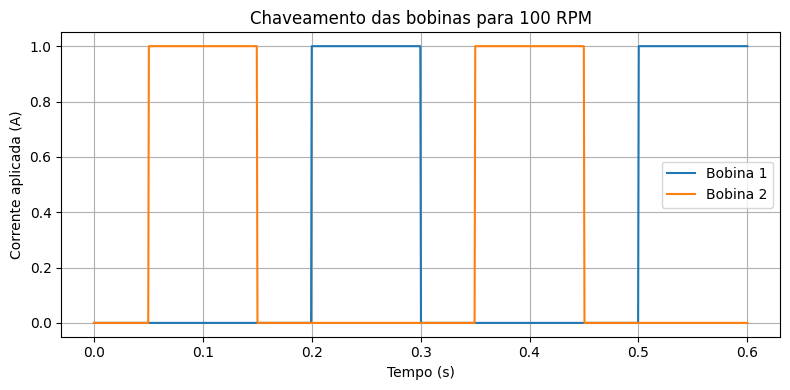

In [13]:
# Controle de velocidade para 100 RPM:
# Tempo de uma volta: T_volta = 60 / RPM = 0.6 s para 100 RPM.
# O controlador monitora a posição do rotor (0 a 360°) e aplica corrente nos intervalos:
# Bobina 1: 120°-180° e 300°-360° | Bobina 2: 30°-90° e 210°-270°
# Fora desses intervalos, as bobinas ficam desligadas.
# O chaveamento é sincronizado com a rotação para garantir torque e velocidade constante.
# Cada bobina é energizada duas vezes por volta; o gráfico mostra esses períodos.

import numpy as np
import matplotlib.pyplot as plt

def corrente_bobina11(angulo):
    """Calcula a corrente da Bobina 1 com base no ângulo do rotor."""
    # A bobina 1 está ligada em 120°-180° e 300°-360°
    if (120 <= angulo <= 180) or (300 <= angulo <= 360):
        return 1  # Corrente ligada
    else:
        return 0  # Corrente desligada

def corrente_bobina22(angulo):
    """Calcula a corrente da Bobina 2 com base no ângulo do rotor."""
    # A bobina 2 está ligada em 30°-90° e 210°-270°
    if (30 <= angulo <= 90) or (210 <= angulo <= 270):
        return 1  # Corrente ligada
    else:
        return 0  # Corrente desligada

# 1. Parâmetros do sistema
rpm = 100                          # Velocidade desejada em rotações por minuto
T_volta = 60 / rpm                 # Tempo de uma volta (segundos) -> T_volta = 60 / RPM
n_steps = 1000                     # Número de pontos para simulação

# 2. Vetores de posição do rotor e tempo
theta_graus = np.linspace(0, 360, n_steps)   # Posição do rotor em graus (0 a 360°)
tempo = np.linspace(0, T_volta, n_steps)     # Tempo para uma volta completa


# 4. Simulação do controle
# Para cada posição do rotor, calcula a corrente aplicada em cada bobina
corrente1 = np.array([corrente_bobina11(ang) for ang in theta_graus])
corrente2 = np.array([corrente_bobina22(ang) for ang in theta_graus])

# 5. Gráfico do chaveamento das bobinas
plt.figure(figsize=(8,4))
plt.plot(tempo, corrente1, label='Bobina 1')
plt.plot(tempo, corrente2, label='Bobina 2')
plt.xlabel('Tempo (s)')
plt.ylabel('Corrente aplicada (A)')
plt.title('Chaveamento das bobinas para 100 RPM')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- Tópico 8
- Nessas condições, considerando o núcleo como sendo ideal, determine a razão
entre a potência mecânica desenvolvida pelo motor e a potência necessária para
o sistema de acionamento

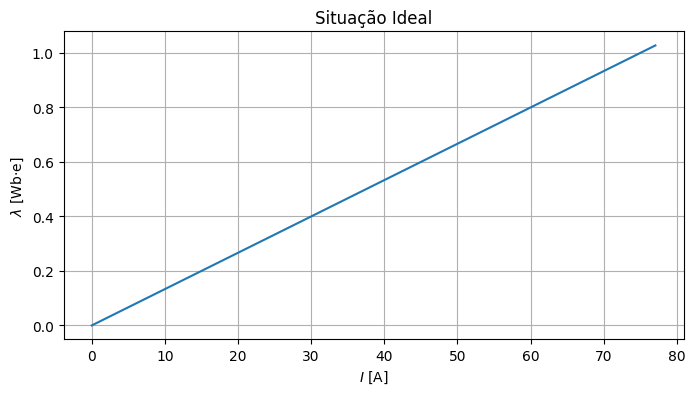

θ = 0°: Razão = 74.34%
θ = 12°: Razão = 71.73%
θ = 24°: Razão = 68.43%
θ = 36°: Razão = 66.44%
θ = 48°: Razão = 66.44%
θ = 60°: Razão = 66.44%


In [14]:
area_ref = area_eficaz(0)
fluxo = N1 * DensidadeCampo * area_ref

# Ideal para 10°
B_g = (DensidadeCampo * area_ref) / max(area_eficaz(np.pi/18), 1e-12)
I_ideal = (B_g * 2 * g / U0) / N1

plt.figure(figsize=(8,4))
plt.plot(I_ideal, fluxo)
plt.title("Situação Ideal"); plt.ylabel(r"$\lambda$ [Wb·e]"); plt.xlabel(r"$I$ [A]")
plt.grid(True); plt.show()

# Razão P_motor/P_ac para 0-60°
for ang in np.radians([0, 12, 24, 36, 48, 60]):
    Aang = area_eficaz(ang)
    B_g = (DensidadeCampo * area_ref) / Aang if Aang != 0 else 0

    I_real = (CampoMagnetico*lc + B_g*2*g/U0) / N1
    order = np.argsort(I_real)
    I_sort, lam_sort = I_real[order], fluxo[order]

    I_uniq, idx = np.unique(I_sort, return_index=True)
    lam_uniq = lam_sort[idx]

    if len(I_uniq) > 1:
        Wc = trapezoid(lam_uniq, I_uniq)
        Wf = trapezoid(I_uniq, lam_uniq)
        razao = Wc / (Wf + Wc)
    else:
        razao = 0

    print(f"θ = {np.degrees(ang):.0f}°: Razão = {razao:.2%}")

- Tópico 9
- Nessas condições, considerando a característica real do núcleo, determine a
razão entre a potência mecânica desenvolvida pelo motor e a potência
necessária para o sistema de acionamento.

θ = 0.0° | Eficiência Real = 74.34%
θ = 12.0° | Eficiência Real = 71.73%
θ = 24.0° | Eficiência Real = 68.43%
θ = 36.0° | Eficiência Real = 66.44%
θ = 48.0° | Eficiência Real = 66.44%
θ = 60.0° | Eficiência Real = 66.44%


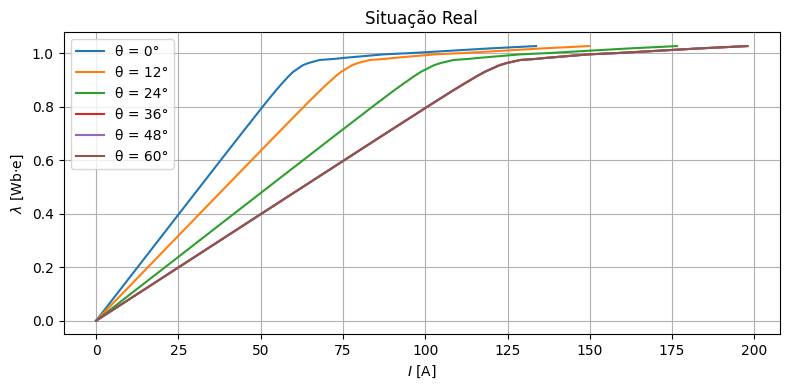

In [15]:
# --- Topico 9: Razão entre energia mecânica e energia elétrica (núcleo real) ---

# Ângulos de teste (0° a 60°)
angulos_deg = np.linspace(0, 60, 6)
angulos_rad = np.radians(angulos_deg)

plt.figure(figsize=(8, 4))
plt.title("Situação Real")
plt.ylabel(r"$\lambda$ [Wb·e]")
plt.xlabel(r"$I$ [A]")

for theta in angulos_rad:
    area_atual = area_eficaz(theta)
    if area_atual == 0:
        continue

    # Calcula vetores de corrente e fluxo para cada posição
    campo_bg = (DensidadeCampo * area_ref) / area_atual
    corrente_real = (CampoMagnetico * lc + (campo_bg * 2 * g) / U0) / N1
    fluxo_real = N1 * DensidadeCampo * area_ref

    # Integra para obter energias
    energia_motor = trapezoid(fluxo_real, corrente_real)
    energia_acionamento = energia_motor + trapezoid(corrente_real, fluxo_real)
    eficiencia = energia_motor / energia_acionamento if energia_acionamento != 0 else 0

    print(f"θ = {np.degrees(theta):.1f}° | Eficiência Real = {eficiencia:.2%}")

    plt.plot(corrente_real, fluxo_real, label=f"θ = {np.degrees(theta):.0f}°")

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()